## Preferencia y recambio de automóviles en Chile.
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

##### Notebook desarrollado por Alfredo Pasmiño F.
Agosto 2018

## Metodología
El siguiente análisis se realizó utilizando Python ver. 3.6. El objetivo es analizar el dataset y aplicar algunas técnicas de visualización y aprendizaje no supervisado para el agrupamiento de datos, así para finalmente sacar alguna conclusión.</p>
El análisis comprende las siguientes etapas:

1. Limpieza y exploración de datos
2. Análisis de correspondencia
3. Agrupamiento con KModes
4. Conclusiones

Las principales librerías utilizadas son Pandas, Numpy, Matplotlib y Seaborn

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

## 1. Limpieza y Exploración de datos

Primero cargamos en memoria el archivo .csv y lo transformamos en un Dataframe de Python.

In [2]:
#ruta del directorio
ruta='C:/Users/apasmino/Documents/Python Scripts/'

#leemos el archivo
df=pd.read_csv(ruta+'bbdd_prueba_corp.csv', sep=';',  encoding = 'ISO-8859-1', decimal=',', header=0, na_values=' ')

In [3]:
#visualizamos los primeros 5 registros
df.head()

,PATENTE,MARCA,MODELO,ANIO,ID_CLIENTE,COMUNA,REGION,SEXO,ACTIVIDAD,TASACION,FEC_TRANSFERENCIA,COLOR,EDAD,VIGENCIA
0,393A4B4C-085,TOYOTA,RAV 4,2015,50838335,TEMUCO,9,M,NaN,11947500.0,NaN,BLANCO,NaN,N
1,B1F3DB7E-F67,MAZDA,CX 5,2016,46322649,VILLA ALEMANA,5,M,NaN,NaN,NaN,NEGRO,38.0,S
2,F6DBB2E6-A76,GREAT WALL,HAVAL NEW H3 2.0,2014,36226810,ANTOFAGASTA,DE ANTOFAGASTA,NaN,NaN,NaN,NaN,NEGRO,49.0,S
3,EBCF63CD-99D,JEEP,COMPASS SPORT 2.4,2013,43482783,NaN,NaN,NaN,NaN,NaN,20160418.0,GRIS,40.0,S
4,FF38B368-B0F,SUBARU,FORESTER 2.0,2017,25657273,NaN,NaN,NaN,NaN,NaN,NaN,GRIS,62.0,S


A simple vista se puede apreciar que existen datos faltantes y que la variable Región tiene la clave y el nombre en sus registros, revisaremos cada variable para ver si es necesario aplicar alguna técnica de limpieza, imputación o correccion en los datos.

In [4]:
#dimensión, cuantas filas y columnas tiene el .csv
df.shape

(1006969, 14)

El archivo contiene 1.006.969 registros con 14 variables, revisaremos en un análisis exploratorio el dataset para ver si contiene datos missing o faltantes, outlaiers o atípicos, etc.

In [5]:
#información cada variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006969 entries, 0 to 1006968
Data columns (total 14 columns):
PATENTE              1006969 non-null object
MARCA                1006274 non-null object
MODELO               1006675 non-null object
ANIO                 1006969 non-null int64
ID_CLIENTE           1006969 non-null int64
COMUNA               541207 non-null object
REGION               561145 non-null object
SEXO                 122608 non-null object
ACTIVIDAD            197779 non-null float64
TASACION             609000 non-null float64
FEC_TRANSFERENCIA    341152 non-null float64
COLOR                994400 non-null object
EDAD                 723490 non-null float64
VIGENCIA             1006969 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 107.6+ MB


Tenemos variables numéricas (float64 e int64) y categóricas (object), a simple vista se puede apreciar que hay datos missing ya que no todas las variables tienen el total de 1.006.969 registros, a continuación revisaremos cada variable si contiene datos atípicos en forma detallada.

## 1.1 Datos outliers

In [6]:
#estadisticos básicos
pd.options.display.float_format = '{:.0f}'.format
df.describe()

,ANIO,ID_CLIENTE,ACTIVIDAD,TASACION,FEC_TRANSFERENCIA,EDAD
count,1006969,1006969,197779,609000,341152,723490
mean,2014,56500043,0,5826111,20151804,49
std,2,64398526,0,6472823,16814,13
min,2010,0,0,0,20091015,3
25%,2012,29023307,0,0,20140704,39
50%,2013,40627585,0,5955000,20151202,48
75%,2015,50742038,0,10000000,20170116,58
max,2018,329820688,0,91880000,20180111,134


Al revisar los estadísticos básicos se puede apreciar que existen valores atípicos en la tasación (el mínimo es 0), igual que en la edad ya que existe una persona con 3 años en el mínimo y 134 años en el máximo. Debemos tener cuidado con la variable Tasación ya que su percentil 25 tiene un monto de tasación 0 por lo que podríamos llegar a conclusiones erróneas.
La variable actividad no es relevante ya que tiene 0 en todos sus registros por lo que es dificil que nos entregue información útil, la variable id_cliente me serviría para contar cuantos personas únicas tienen un vehículo o cuantas peronas tienen mas de 1.

In [7]:
#función para grficar un boxplot
def boxPlotGrafico(xcolumn, ycolumn):
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 3)
    sns.boxplot( xcolumn, y= ycolumn)

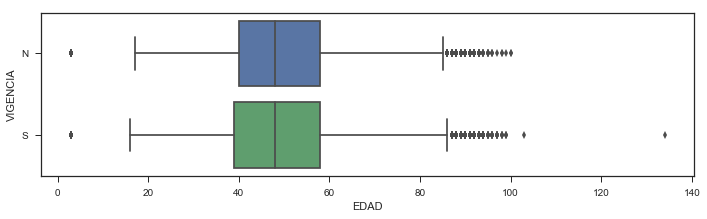

In [8]:
#boxplot de edad y vigencia
sns.set()
boxPlotGrafico( df['EDAD'], df['VIGENCIA'])

En el boxplot puedo graficar e interpretar que la variable edad para los que estan vigentes como para los que no estan vigente, tiene datos atípicos (los puntos que están fuera del límite inferior y superior del boxplot) en este caso son personas cercana a 1 y mayores a 85 años. revisaremos en mayor detalle cuantos personas menores de 18 años y mayores de 100 años tengo en mi dataset.

In [9]:
print("Total de datos atípicos:") 
print(df[df['EDAD'] > 100].count()['EDAD']+df[df['EDAD'] < 18].count()['EDAD'] )


print("\n% del total en la variable de edad: ")
print((df[df['EDAD'] > 100].count()['EDAD']+df[df['EDAD'] < 18].count()['EDAD'])/df['EDAD'].count()*100)

Total de datos atípicos:
96

% del total en la variable de edad: 
0.013269015466696154


Revisando la variable edad, considero como datos atípicos aquellos que tienen menos de 18 años (considerando que no tienen poder adquisitivo para adquirir un vehículo) y mas de 100 años, en total son 96 registros lo que equivale a un 0.013% del total de los registros.
Para estos casos imputaremos estos registros ya que posteriormente aplicaremos un algoritmo de agrupación para crear segmentos.

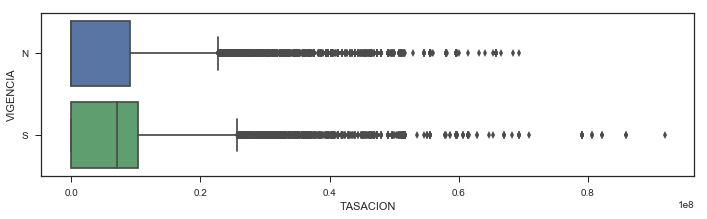

In [10]:
#boxplot tasación
boxPlotGrafico( df['TASACION'], df['VIGENCIA'])

En el boxplot de la variable tasación muestra que el límite inferior es 0, esto se podría interpretar que son datos no ingresados o faltantes, además tengo datos atípicos por montos superiores a 20 millones en la tasación de los vehículos. esto se podría interpretar que son de alta gama que revisaremos a continuación.

In [11]:
df.loc[(df['TASACION'] > 80000000)].head()

,PATENTE,MARCA,MODELO,ANIO,ID_CLIENTE,COMUNA,REGION,SEXO,ACTIVIDAD,TASACION,FEC_TRANSFERENCIA,COLOR,EDAD,VIGENCIA
118141,7F801237-D9F,LAND ROVER,RANGE ROVER 5.0,2016,28604632,NaN,NaN,NaN,nan,85905000,nan,GRIS,57,S
236108,51CAC5D6-37B,LAND ROVER,RANGE ROVER VOGUE 3.0,2016,25872823,NaN,NaN,NaN,nan,80665000,nan,AZUL,55,S
326863,7D9A147F-856,LAND ROVER,RANGE ROVER 5.0,2016,20981712,NaN,NaN,NaN,nan,85905000,nan,VERDE,65,S
421253,15A86808-962,LAND ROVER,RANGE ROVER 4.4,2016,27557369,NaN,NaN,NaN,nan,82240000,nan,GRIS,50,S
524206,04005394-7B3,LAND ROVER,RANGE ROVER VOGUE 5.0,2016,31938664,NaN,NaN,NaN,nan,91880000,nan,BLANCO,nan,S


Los de mas alta tasación son vehículos de marca Land Rover, realizando una pequeña búsqueda en internet puedo comprobar que su monto de venta es similar por lo que su tasación esta correcta según nuestro mercado.

## 1.2 Datos Missing

In [12]:
print("*****La suma de los missing en el dataset es:*****")
print(df.isna().sum())

print("*****El porcentaje de los missing en el dataset es:*****")
print(df.isna().sum() /df.shape[0]*100)

*****La suma de los missing en el dataset es:*****
PATENTE                   0
MARCA                   695
MODELO                  294
ANIO                      0
ID_CLIENTE                0
COMUNA               465762
REGION               445824
SEXO                 884361
ACTIVIDAD            809190
TASACION             397969
FEC_TRANSFERENCIA    665817
COLOR                 12569
EDAD                 283479
VIGENCIA                  0
dtype: int64
*****El porcentaje de los missing en el dataset es:*****
PATENTE              0
MARCA                0
MODELO               0
ANIO                 0
ID_CLIENTE           0
COMUNA              46
REGION              44
SEXO                88
ACTIVIDAD           80
TASACION            40
FEC_TRANSFERENCIA   66
COLOR                1
EDAD                28
VIGENCIA             0
dtype: float64


En el dataset tiene una gran cantidad de datos missing, por ejemplo la variable sexo un 88% de sus registros estan faltante por lo que no puedo eliminarlos. Para ello se creará una nueva categoría llamada "No identificado" y se imputaran todos los faltantes a esta categoría.

Para la variable tasación la estrategia de imputación será formar una clave compuesta por Marca, Modelo y Año luego se sacará el promedio de tasación y se llenaran los faltantes en base a esa estrategia, para los que aún permanezcan como faltantes los marcaremos como NaN.

Para las variables Edad y los faltates de Tasación la estrategía de imputación será marcar estos valores como NaN, en python estos valores son ignorados por operadores que suman, cuentan, etc. debido a  que es un porcentaje alto es mucho mejor la estrategia de "marca", que imputarlos por el promedio, la moda o alguna otra variable que nos lleve a cometer algún error de interpretación en nuestro análisis como por ejemplo la tasación que tiene montos en 0.

In [13]:
#imputación en base de marca, modelo y año del vehículo
df['TASACION']=df.groupby(['MARCA', 'MODELO', 'ANIO'])['TASACION'].apply(lambda x: x.fillna(x.mean()))

In [14]:
#Marcamos valores que son cero como missing o NaN y nos aseguramos que todas los valores sean de este tipo
df[['EDAD', 'TASACION', 'ACTIVIDAD']] = df[['EDAD', 'TASACION', 'ACTIVIDAD']].replace(0, np.NaN)

Para la variable Región en la revisión del dataset tenemos la clave y el nombre, limpiaremos estos registros dejando solo el nombre donde su código de región sea igual.

In [15]:
#registros únicos
df['REGION'].unique()

array(['9', '5', 'DE ANTOFAGASTA', nan,
       'DEL LIBERTADOR BERNARDO OHIGGINS', 'METROPOLITANA DE SANTIAGO',
       'DEL BIO BIO', '10', '13', '8', 'DE COQUIMBO', '2', '6',
       'DE VALPARAISO', '0', '3', 'DE LA ARAUCANIA', 'DE LOS RIOS', '7',
       'DEL MAULE', 'DE LOS LAGOS', '4', '1', 'DE ATACAMA',
       'DE MAGALLANES Y ANTARTICA CHILENA', '14',
       'AYSEN DEL GENERAL CARLOS IBANEZ', '12', 'DE TARAPACA', '15', '11',
       'DE ARICA y PARINACOTA'], dtype=object)

In [16]:
#función que evalúa el id de la región

def regiones(region):
    if region=='1':
        return "DE TARAPACA"
    elif region=='2':
        return "DE ANTOFAGASTA"
    elif region=='3':
        return "DE ATACAMA"
    elif region=='4':
        return "DE COQUIMBO"
    elif region=='5':
        return "DE VALPARAISO"
    elif region=='6':
        return "DEL LIBERTADOR BERNARDO OHIGGINS"
    elif region=='7':
        return "DEL MAULE"
    elif region=='8':
        return "DEL BIO BIO"
    elif region=='9':
        return "DE LA ARAUCANIA"
    elif region=='10':
        return "DE LOS LAGOS"
    elif region=='11':
        return "AYSEN DEL GENERAL CARLOS IBANEZ"
    elif region=='12':
        return "DE MAGALLANES Y ANTARTICA CHILENA"
    elif region=='13':
        return "METROPOLITANA DE SANTIAGO"
    elif region=='14':
        return "DE LOS RIOS"
    elif region=='15':
        return "DE ARICA y PARINACOTA"
    elif region=='0':
        return "No identificado"
    else:
      return region

In [17]:
#evaluamos la región
df['REGION']=df['REGION'].apply(regiones)

Para las variables categóricas Marca, Modelo, Comuna, Región (que sigan faltantes), Sexo y Color la estrategía de imputación, al ser un porcentaje significativo de hasta un 88% en la variable sexo, será crear una nueva categoría llamada "No identificado"

In [18]:
#para datos nan
df[['MARCA', 'SEXO','MODELO', 'REGION', 'COMUNA', 'ACTIVIDAD' ]] = df[['MARCA', 'SEXO','MODELO',
                                                          'REGION', 'COMUNA', 'ACTIVIDAD' ]].replace(np.NaN, 'No identificado')

Verificamos que los datos se han imputado.

In [19]:
df.head()

,PATENTE,MARCA,MODELO,ANIO,ID_CLIENTE,COMUNA,REGION,SEXO,ACTIVIDAD,TASACION,FEC_TRANSFERENCIA,COLOR,EDAD,VIGENCIA
0,393A4B4C-085,TOYOTA,RAV 4,2015,50838335,TEMUCO,DE LA ARAUCANIA,M,No identificado,11947500,nan,BLANCO,nan,N
1,B1F3DB7E-F67,MAZDA,CX 5,2016,46322649,VILLA ALEMANA,DE VALPARAISO,M,No identificado,13537051,nan,NEGRO,38,S
2,F6DBB2E6-A76,GREAT WALL,HAVAL NEW H3 2.0,2014,36226810,ANTOFAGASTA,DE ANTOFAGASTA,No identificado,No identificado,6150000,nan,NEGRO,49,S
3,EBCF63CD-99D,JEEP,COMPASS SPORT 2.4,2013,43482783,No identificado,No identificado,No identificado,No identificado,nan,20160418,GRIS,40,S
4,FF38B368-B0F,SUBARU,FORESTER 2.0,2017,25657273,No identificado,No identificado,No identificado,No identificado,nan,nan,GRIS,62,S


Nuestro dataframe quedó modificado y ahora realizaremos algunas gráficas, veremos la distribución de las variables númericas con un histograma y para las variables categóricas revisaremos la frecuencia de cada categoría.

## 1.3 Gráficos

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023E41C2CEB8>,
      dtype=object)

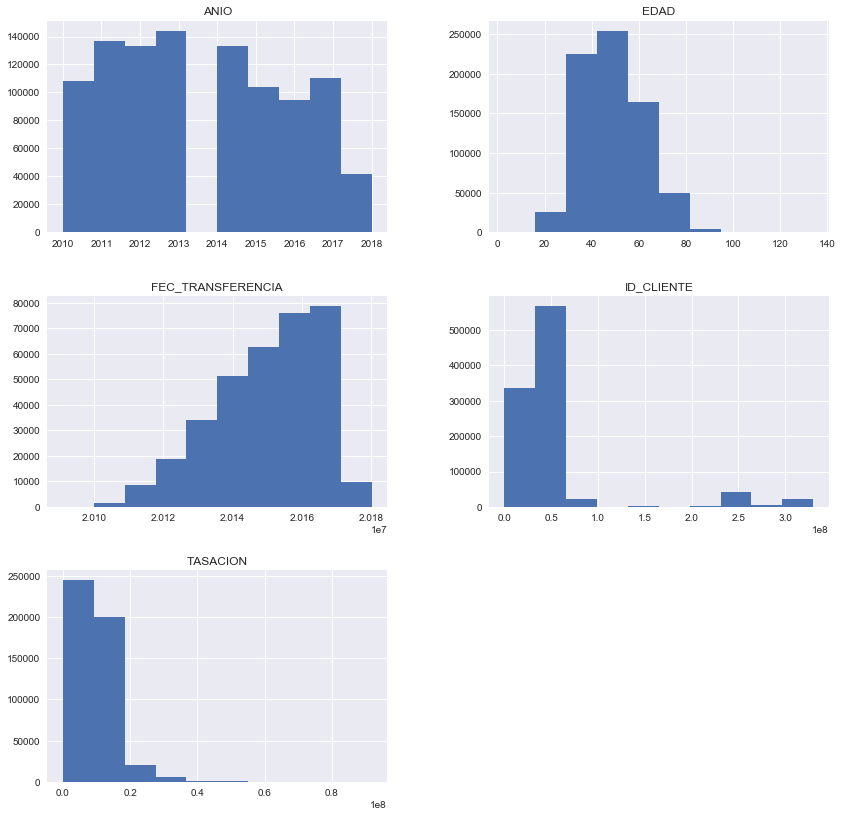

In [20]:
sns.set()
df[df.dtypes[(df.dtypes=="float64")|(df.dtypes=="int64")].index.values].hist(figsize=[14,14])

Se puede apreciar en el histógrama la distribución de las variables, en nuestro estudio del parque automotriz los vehículos del año 2013 son lo aparecen en el punto mas alto del gráfico de "ANIO", se aprecia una caída continua en los vehículos de años 2014, 2015 y 2016 repuntando el 2017.

El gráfico de "EDAD" se aprecia que el punto alto corresponde a la cantidad de personas entre los 40 y 50 años, las colas se encuentran entre los 18-20 años y pasado lo 80 años. La "FECHA DE TRANSFERENCIA" se aprecia una escalada creciente a partir del 2010 y en la variable "TASACION" se aprecia facilmente que la mayor cantidad se encuentra en vehículos tasados bajo los 20 millones, siendo e punto más alto bajo los 10 millones.

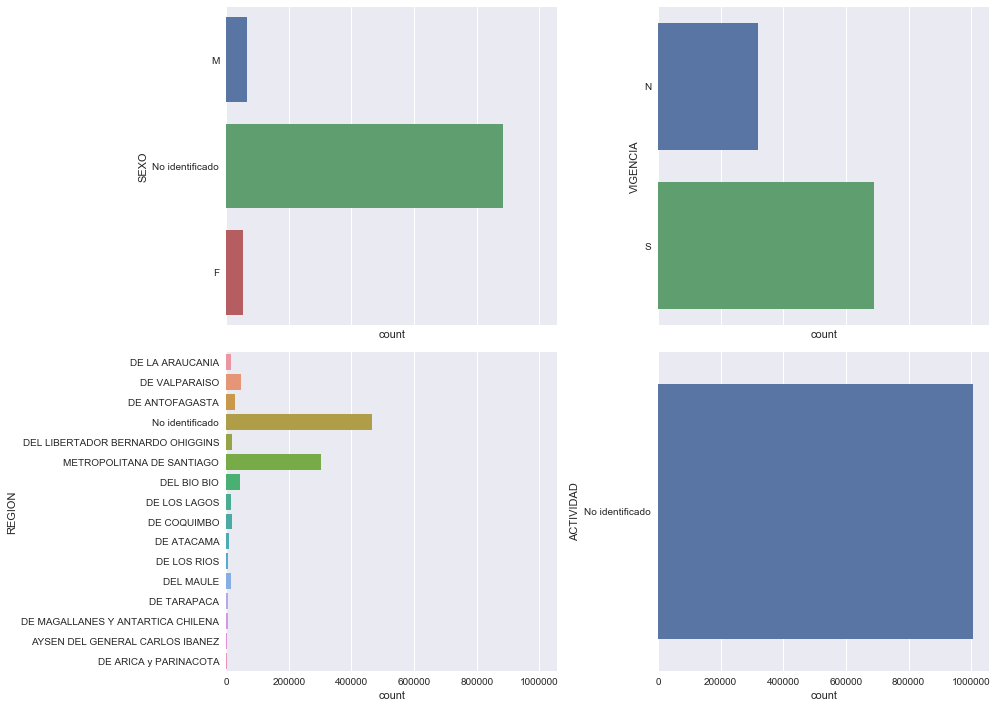

In [21]:
#graficamos las variables categóricas
dfCategorial=df[['SEXO', 'VIGENCIA', 'REGION', 'ACTIVIDAD']]
fig, axes =plt.subplots(2,2, figsize=(14,10), sharex=True)
axes = axes.flatten()
object_bol = dfCategorial.dtypes == 'object'
for ax, catplot in zip(axes, dfCategorial.dtypes[object_bol].index):
    sns.countplot(y=catplot, data=dfCategorial, ax=ax)

plt.tight_layout()  
plt.show()

En los gráficos de barra se aprecia en la variable "SEXO" claramente tenemos muchos datos faltantes, así como el total de la variable "ACTIVIDAD" tiene un 100% de datos faltantes que imputamos anteriormente.
Se aprecia en la variable "REGION" que sin considerar los no identificados la que aparece con mayor frequencia es la región Metropolitana de Santiago, seguida de Valparaíso y la región del Bío Bío. también es interesante como los extremo norte y sur del país son la que menos participación tienen el parque automotriz.

## 2. Análisis de Correspondencia

En esta etapa realizaremos un análsis de correspondencia, la cual perteneciente a la familia de técnicas para reducir dimensiones que basicamente nos servirá para poder visualizar diferentes variables cualitativas representadas en un plano en dos dimensiones, la idea es poder ver la posición relativa de unos puntos (de mis variables) tratando de respetar al máximo las posiciones relativas de los puntos en la nube de puntos original.

Primero como en el análsis anterior la región Metropolitana tiene el mayor peso en el parque automotriz, realizaremos un análisis de Pareto donde revisaremos cuales comunas representan al 80% de los vehículos en la región y es donde primero me enfocaría si tuviera que realizar alguna acción comercial al respecto.

In [22]:
#pareto
df_pareto=df[(df['REGION']=='METROPOLITANA DE SANTIAGO') & (df['COMUNA'] != 'No identificado')]
df_pareto=df_pareto.pivot_table(index='COMUNA', values='ANIO', aggfunc='count').sort_values(by='ANIO', ascending=False)
df_pareto['pc']= 100*df_pareto['ANIO']/df_pareto['ANIO'].sum()
df_pareto['pc_ac']=df_pareto['pc'].cumsum()
df_pareto=df_pareto[df_pareto['pc_ac'] <= 80]

Continuaremos nuestro análisis exploratorio, para ello vamos a analisar la región metropolitana considerando que tiene el mayor volumen en el parque automotriz y se filtrará por aquellas comunas que quedaron en la categoría No identificadas.
Se construirá una tabla con un análisis de pareto por cantidad de vehículos y trabajaremos con aquellas comunas que representan al menos un 80% en el parque automotriz.

En la tabla quedara la variable ANIO que es la cantidad de autos, "pc" corresponde al porcentaje por comuna y "pc_ac" al porcentaje acumulado.

In [23]:
#almacenamos en la variable lista_comuna las que representan el 80% del parque automotriz
lista_comuna=df_pareto.index.tolist()
df_pareto[df_pareto['pc_ac'] <= 80].head()

,ANIO,pc,pc_ac
COMUNA,,,
LAS CONDES,45799,15,15
SANTIAGO,22283,7,23
PROVIDENCIA,20560,7,29
MAIPU,18269,6,35
VITACURA,16752,6,41


Agregaremos una nueva variable en función de las edades. La idea es agrupar por rango de edad para el análisis.

In [24]:
# Grupo de intervalos según la edad
def edad_grupos(series):
    if series < 18:
        return "18-25 años"
    elif 26 <= series < 36:
        return "25-35 años"
    elif 36 <= series < 46:
        return "36-45 años"
    elif 46 <= series < 56:
        return "46-55 años"
    elif 56 <= series < 66:
        return "56-65 años"
    elif 66 <= series < 76:
        return "66-75 años"
    elif 76 <= series< 86:
        return "76-85 años"   
    elif 86 <= series <= 100:
        return "86-100 años"

Asignaremos variables del dataframe principal df a un dataframe llamado df_ac el cual nos servirá para realizar nuestro análisis de correspondencia.

In [25]:
#nueva variable
df_ac=df[['MARCA','COMUNA', 'REGION', 'SEXO', 'EDAD', 'VIGENCIA', 'COLOR', 'ANIO']]

Se creará una nueva variable categórica en base a las edades, la idea es agrupar para contrastarla con alguna otra variable para el análisis.

In [26]:
#asignamos una nueva variable EDAD_CAT
df_ac['EDAD_CAT']=df['EDAD'].apply(edad_grupos)

A continuación aplicaremos algún filtro, primero revisaremos solo los vehículos vigentes, luego seleccionaremos algunas de las marcas que comercializa Derco y nos enfocaremos en las comunas con mayores registros de automóviles (el 80% acumulado sacado del análisis de Pareto).

In [27]:
#filtros
lista_marca = ['SUZUKI', 'MAZDA', 'JAC','GREAT WALL', 'CHANGAN']

df_ac=df_ac[(df_ac.MARCA.isin(lista_marca) ) & (df_ac.COMUNA.isin(lista_comuna)) & (df_ac['VIGENCIA']=='S')] 

Luego creamos una tabla de contingencia donde analizaremos las categorias de edades según la marca.

In [36]:
#tabla pivote
tabla_ac=df_ac.pivot_table(values='ANIO', index='MARCA', columns=['EDAD_CAT'], aggfunc='count')

In [37]:
tabla_ac=tabla_ac.fillna(0)

In [38]:
#importamos el paquete prince y comenzaremos con 2 componentes

import prince
ca = prince.CA(
n_components=2,
n_iter=3,
copy=True,
engine='auto',
random_state=42,
)

In [39]:
va = ca.fit(tabla_ac)

In [40]:
#varianza explicada
print(va.explained_inertia_ )

[0.6894585061806947, 0.3070971505304569]


La varianza explicada es ceracana a un 90% (68% del primer componente y 30% del segundo componente) esto significa el grado de representación de las variables al ser mostradas en un gráfico en dos dimensiones es un fiel reflejo de la realidad que existe en las variables marca y categoría de edad.

In [41]:
#función grafica el mapa de correspondencia
sns.set()
def Graf_ac(tabla):
    ax = ca.plot_coordinates(
    X=tabla,
    ax=None,
    figsize=(16,10),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True, 
    )

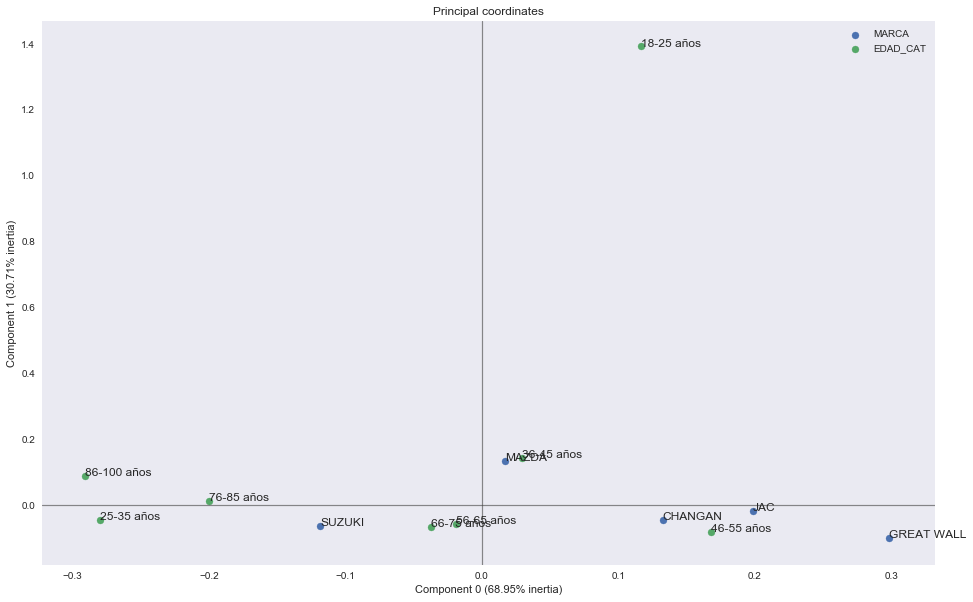

In [42]:
Graf_ac(tabla_ac)

El mapa de correspondencia simple se podría interpretar de la siguiente forma:

Se puede apreciar que marcas como Changan, Great Wall y JAC son de preferencia por personas que tienen un rango de edad entre los 46 a 55 años, es decir que el procentaje de esas marcas en esos intervalos es significativo.
Para Suzuki los rangos de edad donde su porcentaje de participación es sobresaliente, comparado con otras marcas son los intervalos entre 25-35, 66-75 y 76-85 años.
Para Mazda se aprecia que el rango de edad que más participación tiene en la marca son personas entre 36 a 45 años.
Puntos como el rango 86-100 y 18-25 años no son tan relevante ya que estan alejados de todas las marca por lo que personas entre estos rangos no serían los mejores clientes.
Tenemos que tener además consideración que hay una cantidad de registros fuera (los faltantes) ya que quedaron imputados como categoría nan en el proceso previo, quedando excluidos de cualquier tipo de cálculo.

Se realizará otro análsis complementario pero esta vez determinaremos las preferencias de las personas según la relación entre comuna y marcas.

In [43]:
tabla_ac=df_ac.pivot_table(values='ANIO', index='MARCA', columns=['COMUNA'], aggfunc='count')

In [44]:
tabla_ac=tabla_ac.fillna(0)

In [45]:
import prince
ca = prince.CA(
n_components=2,
n_iter=3,
copy=True,
engine='auto',
random_state=42,
)

In [46]:
va = ca.fit(tabla_ac)

In [47]:
print(va.explained_inertia_ )

[0.9316897540043538, 0.04061499476390669]


En este caso la varianza explicada es sobre el 93%, por lo que es una representación fiel de la nube de puntos original.

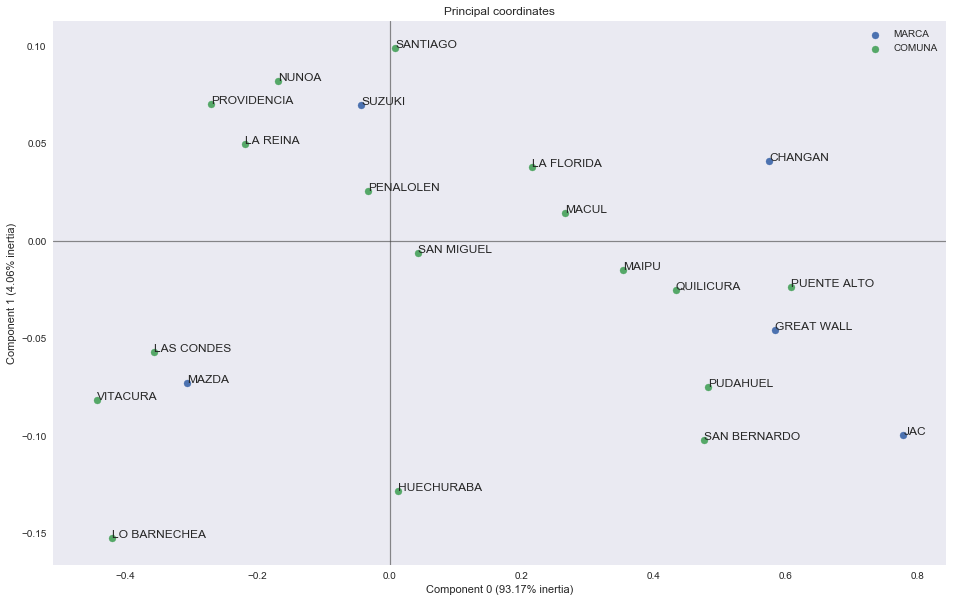

In [48]:
Graf_ac(tabla_ac)

En el mapa de correspondencia se puede apreciar el peso (considerado a nivel porcentual) de las marcas y las comunas más representativas de santiago. por ejemplo comunas como Las Condes, Vitacura y Lo Barnechea Mazda tiene una gran participación.
Suzuki tiene una gran representación en comunas como Santiago, Ñuñoa, Providencia, La Florida y La Reina.</p>
Las comunas en donde Great Wall tiene una importancia relativa son Puente Alto, Quilicura, Maipú y Pudahuel.</p>
Changan se encuentra representada por comunas como La Florida y Puente Alto, finalmente JAC por Pudahuel, San Bernardo y Puente Alto.

## 3. KModes

El siguiente análisis será ver como crear cluster o grupos de personas según algunas variables, utilizando un algoritmo de aprendizaje no supervisado en este caso Kmodes ya que la mayoria de nuestras variables son categóricas usando las modas para representar el centro de los clusters y estas se actualizaran con los valores más frecuentes en cada iteración del proceso.
Selecconamos las variables basadas en las que tienen menor cantidad de datos faltantes.

Se crea un nuevo dataframe llamado df_kmodes las las variables id_cliente (para identificar donde queda agrupado), edad, marca, comuna y color.

In [49]:
#dataframe kmode
df_kmodes=df[['ID_CLIENTE','EDAD' ,'MARCA', 'COMUNA', 'COLOR']]

In [50]:
#aplicamos el mismo grupo de edades
df_kmodes['EDAD_CAT']=df_kmodes['EDAD'].apply(edad_grupos)

In [53]:
#transformamos la variable a un string
from kmodes.kmodes import KModes
syms = df_kmodes.iloc[:, 0]
X = df_kmodes.iloc[:, 2:].apply(lambda x: x.astype('str'))
X.loc[X.EDAD_CAT.isin([None, 'Yes', 'No']), 'EDAD_CAT'] = 'Ninguna'

Evaluaremos en el gráfico de codo el mejor número de cluster, la idea siempre es trabajar con el menor número pero siempre revisando en el gráfico donde en la contribución exista un quiebre y su representación sea cada vez menor.

K: 1  Costo: [2934876.0]
K: 2  Costo: [2934876.0, 2594166.0]
K: 3  Costo: [2934876.0, 2594166.0, 2372672.0]
K: 4  Costo: [2934876.0, 2594166.0, 2372672.0, 2288420.0]
K: 5  Costo: [2934876.0, 2594166.0, 2372672.0, 2288420.0, 2250168.0]
K: 6  Costo: [2934876.0, 2594166.0, 2372672.0, 2288420.0, 2250168.0, 2182842.0]


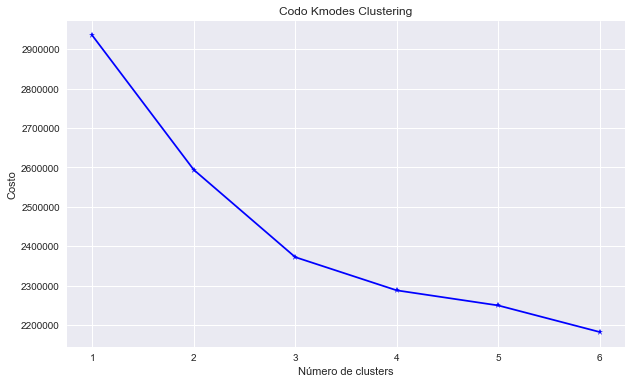

In [56]:
#función que gráfica el código con la inercia por cada k cluster
i=[]
costo=[]
for k in range (1,7):
    i.append(k)
    #creamos un kmodel con k cluster
    kmodes_modelo=KModes(n_clusters=k, init='Cao').fit(X.values, categorical=[0,1,2,3])
    labels=kmodes_modelo.labels_
    costo.append(kmodes_modelo.cost_)
    print('K:', k, ' Costo:', costo)
    
fig=plt.figure()
fig.set_size_inches(10, 6)
ax=fig.add_subplot(111)
ax.plot(i, costo, 'b*-')
plt.grid(True)
plt.xlabel('Número de clusters')
plt.ylabel('Costo')
plt.title('Codo Kmodes Clustering')
plt.figsize=(13,7)

Finalmente utilizaremos 4 cluster que es donde se comienza produce el quiebre en el gráfico y donde la suma de la distancia de los puntos al centroide es cada vez menor, indicando que pueden ser grupos parecidos.

In [57]:
#resutado final
kproto=KModes(n_clusters=4, init='Cao').fit(X.values, categorical=[0,1,2,3])

In [58]:
def imprimir_result(centroide, n_cluster):
    
    print("\n\nResultado:")
    for i, c in enumerate(centroide):
        print('\tCluster %d' % (i+1))
        print('\tCantidad cliente en el cluster: %d' % n_cluster.count(i))

Mostramos la cantidad de personas asignadas a cada cluster

In [59]:
imprimir_result(kproto.cluster_centroids_, kproto.labels_.tolist())



Resultado:
	Cluster 1
	Cantidad cliente en el cluster: 510042
	Cluster 2
	Cantidad cliente en el cluster: 259925
	Cluster 3
	Cantidad cliente en el cluster: 167628
	Cluster 4
	Cantidad cliente en el cluster: 69374


Este es un ejemplo de las 10 primeras personas del dataset y el cluster en que quedaron.

In [62]:
# Print cluster centroids of the trained model.
#print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
#print(kproto.n_iter_)

for s, c in zip(syms[:10], kproto.labels_):
    print("Id cliente: {}, cluster:{}".format(s, c))

2288420.0
Id cliente: 50838335, cluster:0
Id cliente: 46322649, cluster:1
Id cliente: 36226810, cluster:2
Id cliente: 43482783, cluster:0
Id cliente: 25657273, cluster:0
Id cliente: 14210133, cluster:1
Id cliente: 21198752, cluster:3
Id cliente: 24699069, cluster:1
Id cliente: 32883814, cluster:1
Id cliente: 23348761, cluster:0


## 4. Conclusión

Al analizar el dataset se encontro que existe una gran cantidad de variables con datos missing o faltantes, esto implica que se necesita imputar estos registros y tener precaución al momento de realizar algún análisis. Para ello lo primero que se realizó fue un análisis exploratorio donde se detecto estos problemas así como los datos atípicos.
Luego se realizó un análsis de correspondencia donde podemos ver como se relaciona las edades con marcas comercializadas por derco, así como las comunas donde tienen un peso, esto permite en un estudio inicial categorizar por edad, comuna y marca donde se podría generar posteriormente alguna acción comercial con precios, promociones o descuentos a esas personas identificadas.</p>
Se complemento el estudio con una segmentación basada en variables que no tuviesen más de un 35% de datos faltantes, así junto al análisis anterior se obtuvo una base para entender como podría agrupar a mis clientes en base a variables como edad, marca, color y comuna.</p>

El escenario ideal o próximo paso sería unir esto con algún dataset para tener una mayor información de cada persona como nivel educacional, estado civil, ingreso, etc. para tener una mejor claridad y calidad al momento de segmentar o aplicar algún otro tipo de algoritmo.
